In [1]:
from google.cloud import bigquery as bq

In [54]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.metrics import roc_curve, roc_auc_score,accuracy_score, classification_report, confusion_matrix
from sklearn import metrics
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.utils.class_weight import compute_class_weight
import tensorflow as tf
from tensorflow.keras import backend as K

# EDA

In [3]:
conn = bq.Client.from_service_account_json("case.json")

In [4]:
query_ml_1 = """
SELECT
*
FROM case_db.q3_table_user_metrics;
"""

In [5]:
 df_ml_1 = conn.query(query_ml_1).to_dataframe()

In [6]:
df_ml_1

,user_id,country,age,platform,network,time_spend,coin_spend,coin_earn,level_success,level_fail,level_start,booster_spend,booster_earn,coin_amount,event_participate,shop_open,d30_revenue
0,dlxsqb7178890300b2,Zephyra,53,ios,Oyster,71,0,0,0,0,0,0,0,2000,0,0.0,0.00
1,dlxsqb7178884891b2,Thalassia,33,ios,Piggy,88,0,0,0,0,0,0,0,2000,0,0.0,0.00
2,dlxsqb7179152264b2,Sunridge,64,ios,Piggy,2,0,0,0,0,0,0,0,2000,0,0.0,0.00
3,dlxsqb7179044724b2,Zephyra,51,ios,Piggy,11,0,0,0,0,0,0,0,2000,0,0.0,0.00
4,dlxsqb7178985060b2,Zephyra,70,ios,Piggy,38,0,0,0,0,0,0,0,2000,0,0.0,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
342514,dlxsqb7179194267b2,Gleamwood,36,android,Mailbox,35250,191000,161845,255,97,352,120,243,224,1,1.0,166.89
342515,dlxsqb7179183874b2,Emberlyn,26,android,Egg,32984,168500,159555,255,95,350,187,182,260,0,1.0,0.00
342516,dlxsqb7179185878b2,Amaryllis,21,android,Piggy,56505,54000,172020,255,135,390,19,168,23534,0,0.0,0.00
342517,dlxsqb7179005488b2,Windemere,40,android,Piggy,32632,109000,122220,255,88,343,56,130,7012,1,0.0,0.00


In [7]:
# This script prints the data types of each column in the DataFrame `df_ml_1`.
# Useful for verifying that the data types are appropriate for machine learning processing.

print(df_ml_1.dtypes)  # Display data types of DataFrame columns

user_id               object
country               object
age                    Int64
platform              object
network               object
time_spend             Int64
coin_spend             Int64
coin_earn              Int64
level_success          Int64
level_fail             Int64
level_start            Int64
booster_spend          Int64
booster_earn           Int64
coin_amount            Int64
event_participate      Int64
shop_open            float64
d30_revenue          float64
dtype: object


In [8]:
# Remove the 'user_id' column as it's an identifier not useful for modeling
df_ml_1.drop(columns=["user_id"], inplace=True)

## Missing Data

In [9]:
# Check for missing values in each column
df_ml_1.isnull().sum()

,0
country,0
age,0
platform,0
network,0
time_spend,0
coin_spend,0
coin_earn,0
level_success,0
level_fail,0
level_start,0


In [10]:
# This function encodes specified categorical columns in a DataFrame using label encoding.
# It only encodes columns with 'object' dtype from the provided list.

def encode_categorical_columns(df, columns):
    # Select only object-type columns from the specified list
    categorical_columns = df[columns].select_dtypes(include='object').columns

    label_encoder = LabelEncoder()
    for column in categorical_columns:
        # Apply label encoding to each categorical column
        df[column] = label_encoder.fit_transform(df[column])

    return df


In [11]:
# This function categorizes a given age into a defined age group label.

def age_group(age):
    if age < 14:
        return 'Child'
    elif 14 <= age < 20:
        return 'Youth'
    elif 20 <= age < 30:
        return 'Young Adult'
    elif 30 <= age < 65:
        return 'Adult'
    else:
        return 'Elderly'  # Covers ages 65 and above


In [12]:
# Apply transformation to specific column
df_ml_1['age'] = df_ml_1['age'].apply(age_group)
df_ml_1

,country,age,platform,network,time_spend,coin_spend,coin_earn,level_success,level_fail,level_start,booster_spend,booster_earn,coin_amount,event_participate,shop_open,d30_revenue
0,Zephyra,Adult,ios,Oyster,71,0,0,0,0,0,0,0,2000,0,0.0,0.00
1,Thalassia,Adult,ios,Piggy,88,0,0,0,0,0,0,0,2000,0,0.0,0.00
2,Sunridge,Adult,ios,Piggy,2,0,0,0,0,0,0,0,2000,0,0.0,0.00
3,Zephyra,Adult,ios,Piggy,11,0,0,0,0,0,0,0,2000,0,0.0,0.00
4,Zephyra,Elderly,ios,Piggy,38,0,0,0,0,0,0,0,2000,0,0.0,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
342514,Gleamwood,Adult,android,Mailbox,35250,191000,161845,255,97,352,120,243,224,1,1.0,166.89
342515,Emberlyn,Young Adult,android,Egg,32984,168500,159555,255,95,350,187,182,260,0,1.0,0.00
342516,Amaryllis,Young Adult,android,Piggy,56505,54000,172020,255,135,390,19,168,23534,0,0.0,0.00
342517,Windemere,Adult,android,Piggy,32632,109000,122220,255,88,343,56,130,7012,1,0.0,0.00


In [14]:
encode_categorical_columns(df_ml_1,columns=["country","age","platform","network"])

,country,age,platform,network,time_spend,coin_spend,coin_earn,level_success,level_fail,level_start,booster_spend,booster_earn,coin_amount,event_participate,shop_open,d30_revenue
0,19,0,1,10,71,0,0,0,0,0,0,0,2000,0,0.0,0.00
1,17,0,1,11,88,0,0,0,0,0,0,0,2000,0,0.0,0.00
2,16,0,1,11,2,0,0,0,0,0,0,0,2000,0,0.0,0.00
3,19,0,1,11,11,0,0,0,0,0,0,0,2000,0,0.0,0.00
4,19,1,1,11,38,0,0,0,0,0,0,0,2000,0,0.0,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
342514,8,0,0,8,35250,191000,161845,255,97,352,120,243,224,1,1.0,166.89
342515,5,2,0,5,32984,168500,159555,255,95,350,187,182,260,0,1.0,0.00
342516,0,2,0,11,56505,54000,172020,255,135,390,19,168,23534,0,0.0,0.00
342517,18,0,0,11,32632,109000,122220,255,88,343,56,130,7012,1,0.0,0.00


In [17]:
# This block checks and prints the number of unique values for selected columns,
# useful for understanding cardinality in categorical or mixed-type columns.

columns_to_check = ["country", "age", "platform", "network"]

for col in columns_to_check:
    n_unique = df_ml_1[col].nunique()  # Count distinct values in the column
    print(f"Number of unique values in '{col}': {n_unique}")


Number of unique values in 'country': 20
Number of unique values in 'age': 4
Number of unique values in 'platform': 2
Number of unique values in 'network': 14


## Outlier Analysis

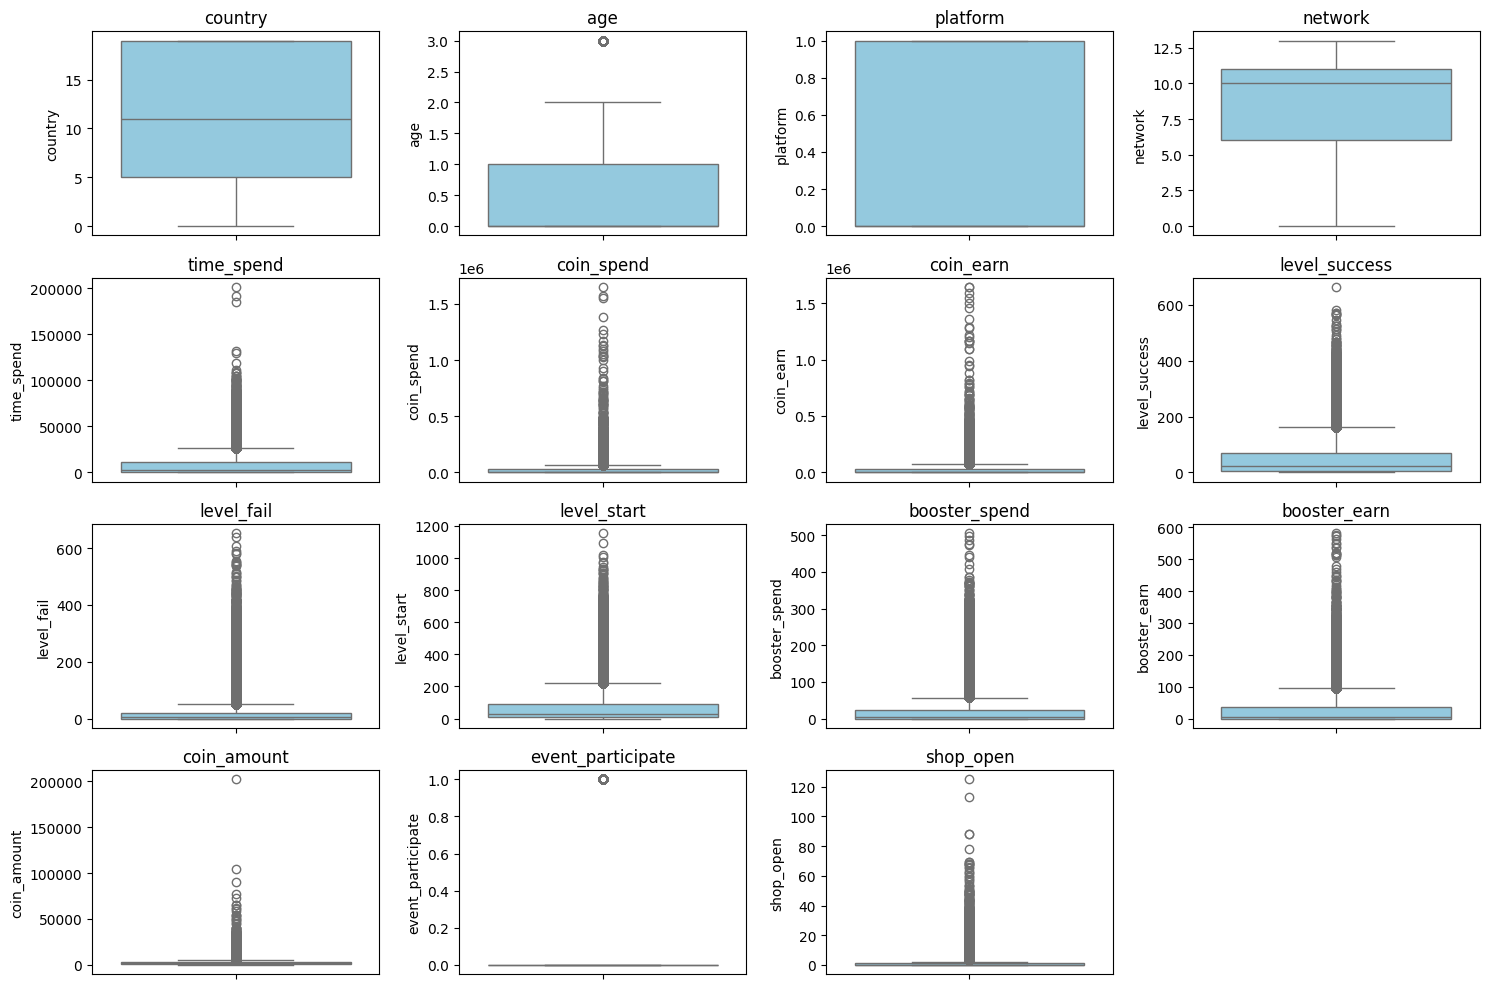

In [20]:
# This block creates boxplots for each feature in the dataset (excluding the target 'd30_revenue')
# to visualize the distribution and detect potential outliers.

X = [column for column in df_ml_1.columns if column not in ["d30_revenue"]]

plt.figure(figsize=(15, 10))
for i, column in enumerate(X, 1):
    plt.subplot(4, 4, i)  # Create a 4x4 grid of subplots
    sns.boxplot(data=df_ml_1, y=column, color='skyblue')  # Boxplot for the current column
    plt.title(column)
    plt.xticks(rotation=45)

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()


## Statistics

In [21]:
# Display summary statistics for all columns, transposed for better readability
df_ml_1.describe().T

,count,mean,std,min,25%,50%,75%,max
country,342519.0,11.268049,6.505433,0.0,5.0,11.0,19.0,19.0
age,342519.0,0.730739,0.945644,0.0,0.0,0.0,1.0,3.0
platform,342519.0,0.486723,0.499824,0.0,0.0,0.0,1.0,1.0
network,342519.0,8.64719,3.129227,0.0,6.0,10.0,11.0,13.0
time_spend,342519.0,7559.453175,10456.431879,0.0,579.0,2851.0,10745.0,201362.0
coin_spend,342519.0,20847.539845,35064.279228,0.0,0.0,4500.0,27000.0,1652000.0
coin_earn,342519.0,23439.894283,36909.192282,0.0,1315.0,7320.0,31820.0,1644045.0
level_success,342519.0,47.267944,59.634493,0.0,6.0,22.0,68.0,665.0
level_fail,342519.0,19.362213,36.787139,0.0,0.0,4.0,21.0,653.0
level_start,342519.0,66.630683,90.504488,0.0,7.0,26.0,93.0,1155.0


## Normalization

In [22]:
# Normalize all features (excluding the target 'd30_revenue') using Min-Max scaling
# This scales each feature to a range between 0 and 1.

selected_columns = df_ml_1.columns.difference(["d30_revenue"])  # Exclude the target column
scaler = MinMaxScaler()
df_ml_1[selected_columns] = scaler.fit_transform(df_ml_1[selected_columns])  # Apply scaling

df_ml_1  # Display the scaled DataFrame


,country,age,platform,network,time_spend,coin_spend,coin_earn,level_success,level_fail,level_start,booster_spend,booster_earn,coin_amount,event_participate,shop_open,d30_revenue
0,1.000000,0.000000,1.0,0.769231,0.000353,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.009890,0.0,0.000,0.00
1,0.894737,0.000000,1.0,0.846154,0.000437,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.009890,0.0,0.000,0.00
2,0.842105,0.000000,1.0,0.846154,0.000010,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.009890,0.0,0.000,0.00
3,1.000000,0.000000,1.0,0.846154,0.000055,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.009890,0.0,0.000,0.00
4,1.000000,0.333333,1.0,0.846154,0.000189,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.009890,0.0,0.000,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
342514,0.421053,0.000000,0.0,0.615385,0.175058,0.115617,0.098443,0.383459,0.148545,0.304762,0.237154,0.417526,0.001108,1.0,0.008,166.89
342515,0.263158,0.666667,0.0,0.384615,0.163804,0.101998,0.097050,0.383459,0.145482,0.303030,0.369565,0.312715,0.001286,0.0,0.008,0.00
342516,0.000000,0.666667,0.0,0.846154,0.280614,0.032688,0.104632,0.383459,0.206738,0.337662,0.037549,0.288660,0.116373,0.0,0.000,0.00
342517,0.947368,0.000000,0.0,0.846154,0.162056,0.065981,0.074341,0.383459,0.134763,0.296970,0.110672,0.223368,0.034674,1.0,0.000,0.00


## Distribution and Correlations

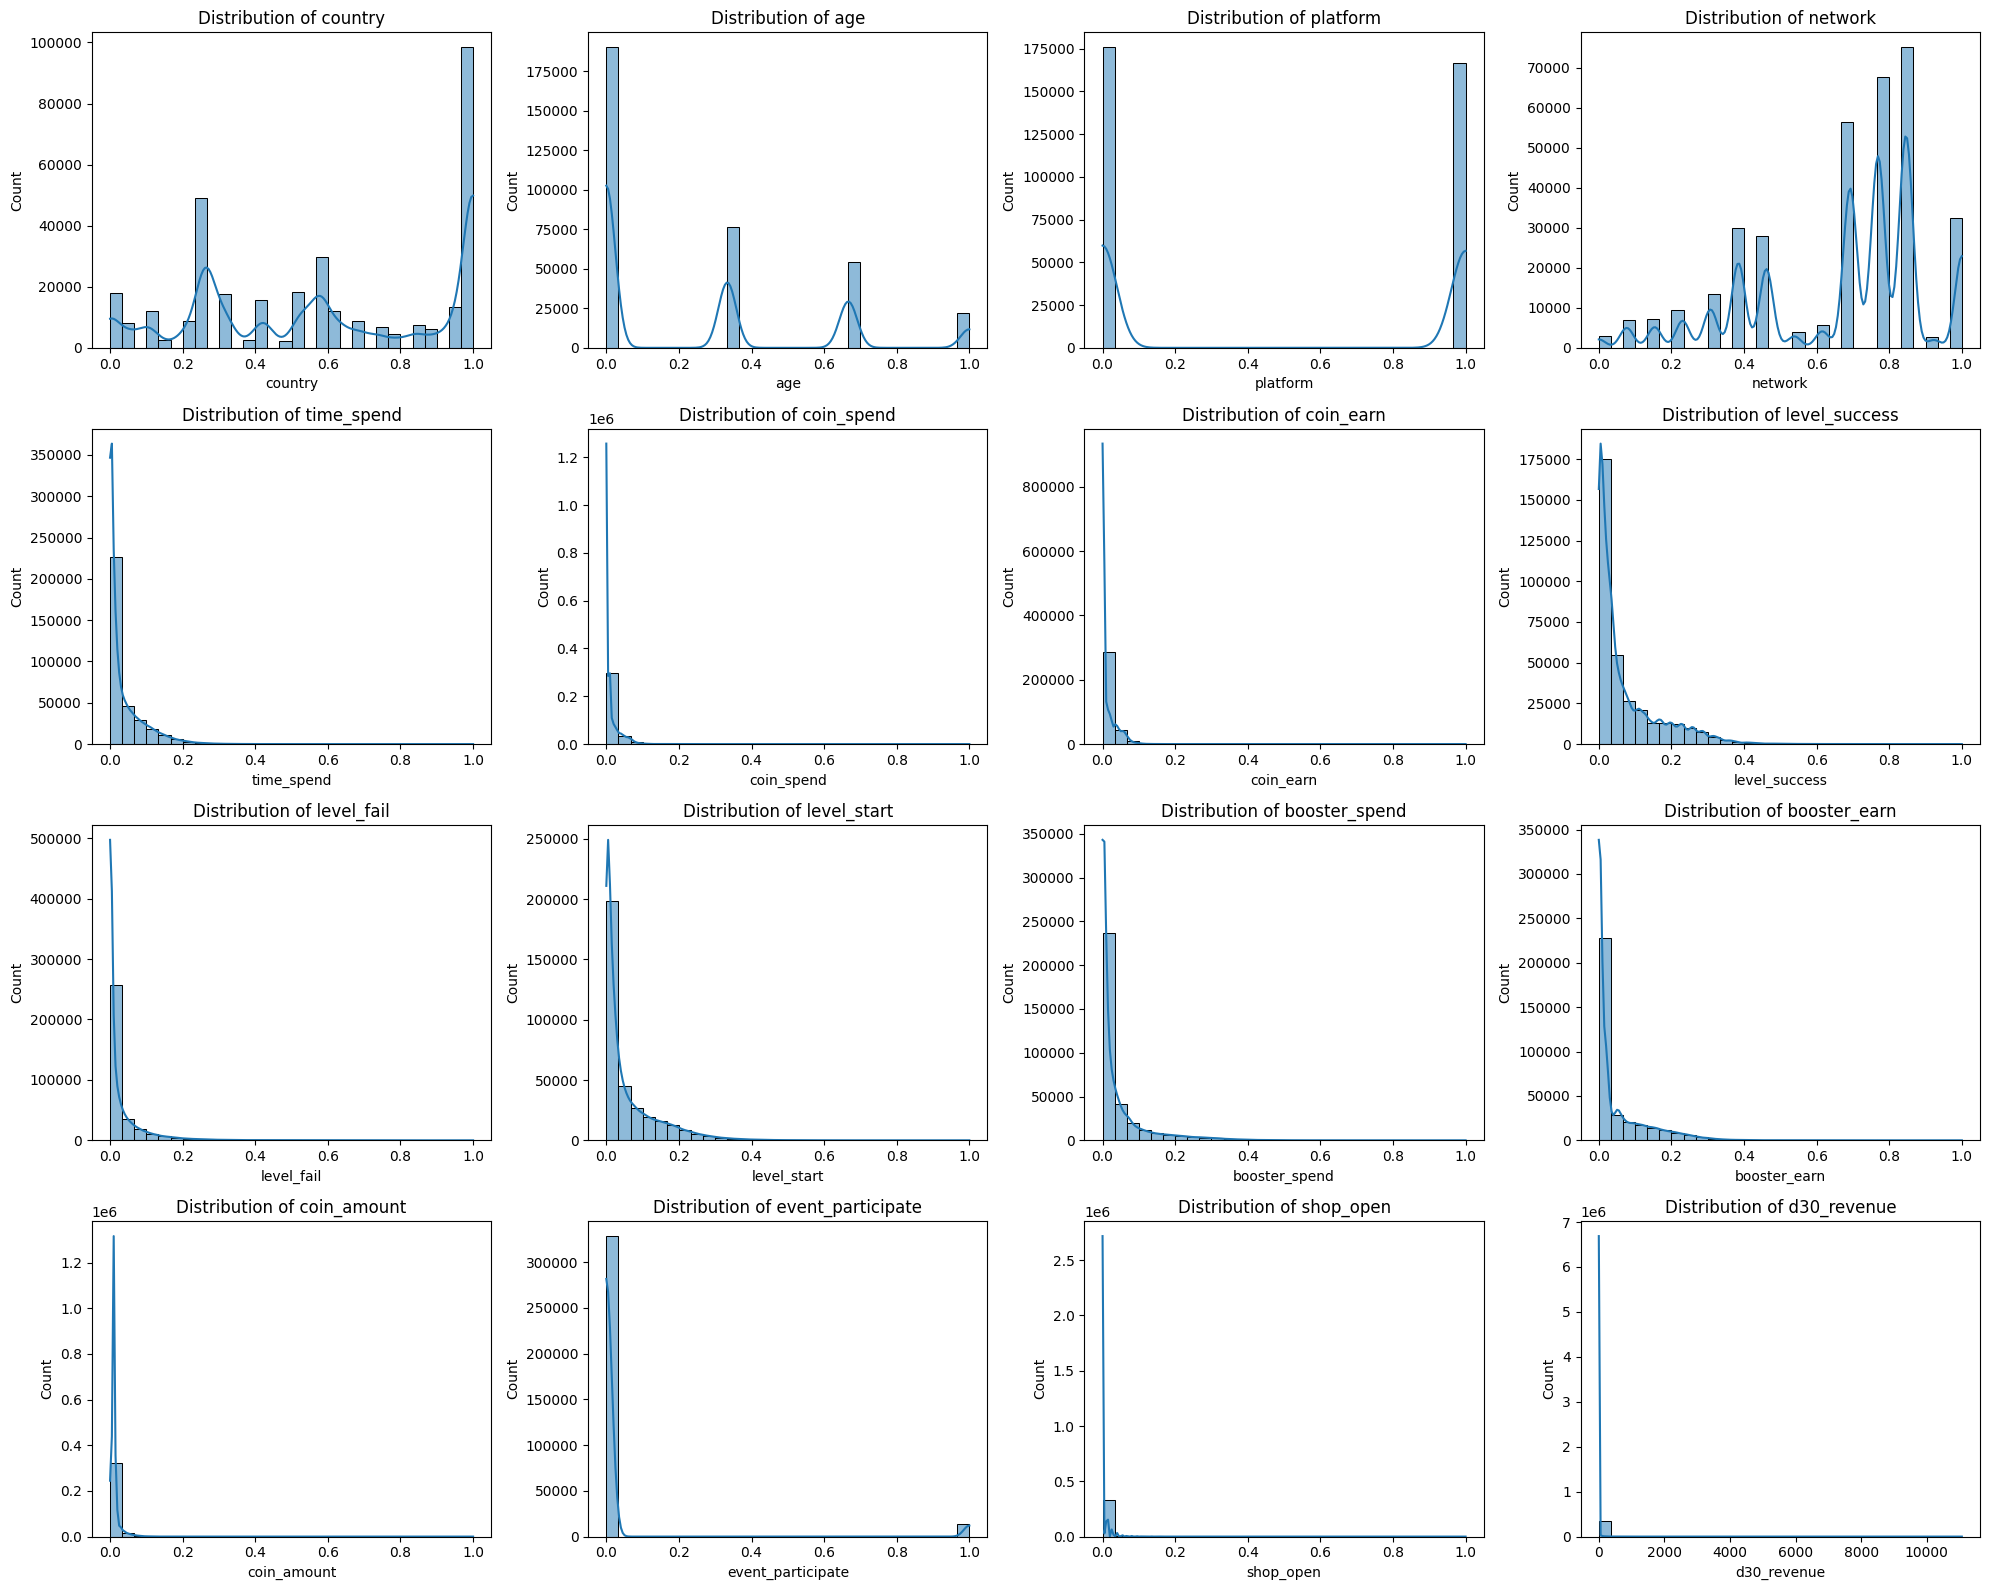

In [25]:
# This script generates a grid of plots to visualize the distribution of all columns in the DataFrame.
# It uses histograms with KDE for numeric columns and count plots for categorical ones.

num_cols = df_ml_1.columns
num_plots = len(num_cols)
rows, cols = 4, 4  # Define subplot grid size

fig, axes = plt.subplots(rows, cols, figsize=(20, 16))
axes = axes.flatten()  # Flatten the 2D axes array for easy indexing

for i, col in enumerate(num_cols):
    ax = axes[i]

    if pd.api.types.is_numeric_dtype(df_ml_1[col]):
        # Plot histogram with KDE for numeric data
        sns.histplot(df_ml_1[col].dropna(), kde=True, ax=ax, bins=30)
        ax.set_title(f"Distribution of {col}")
    else:
        # Plot count of top 10 categories for non-numeric data
        sns.countplot(x=col, data=df_ml_1, ax=ax, order=df_ml_1[col].value_counts().index[:10])
        ax.set_title(f"Count of {col}")
        ax.tick_params(axis='x', rotation=45)  # Rotate x-axis labels for readability

# Remove any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


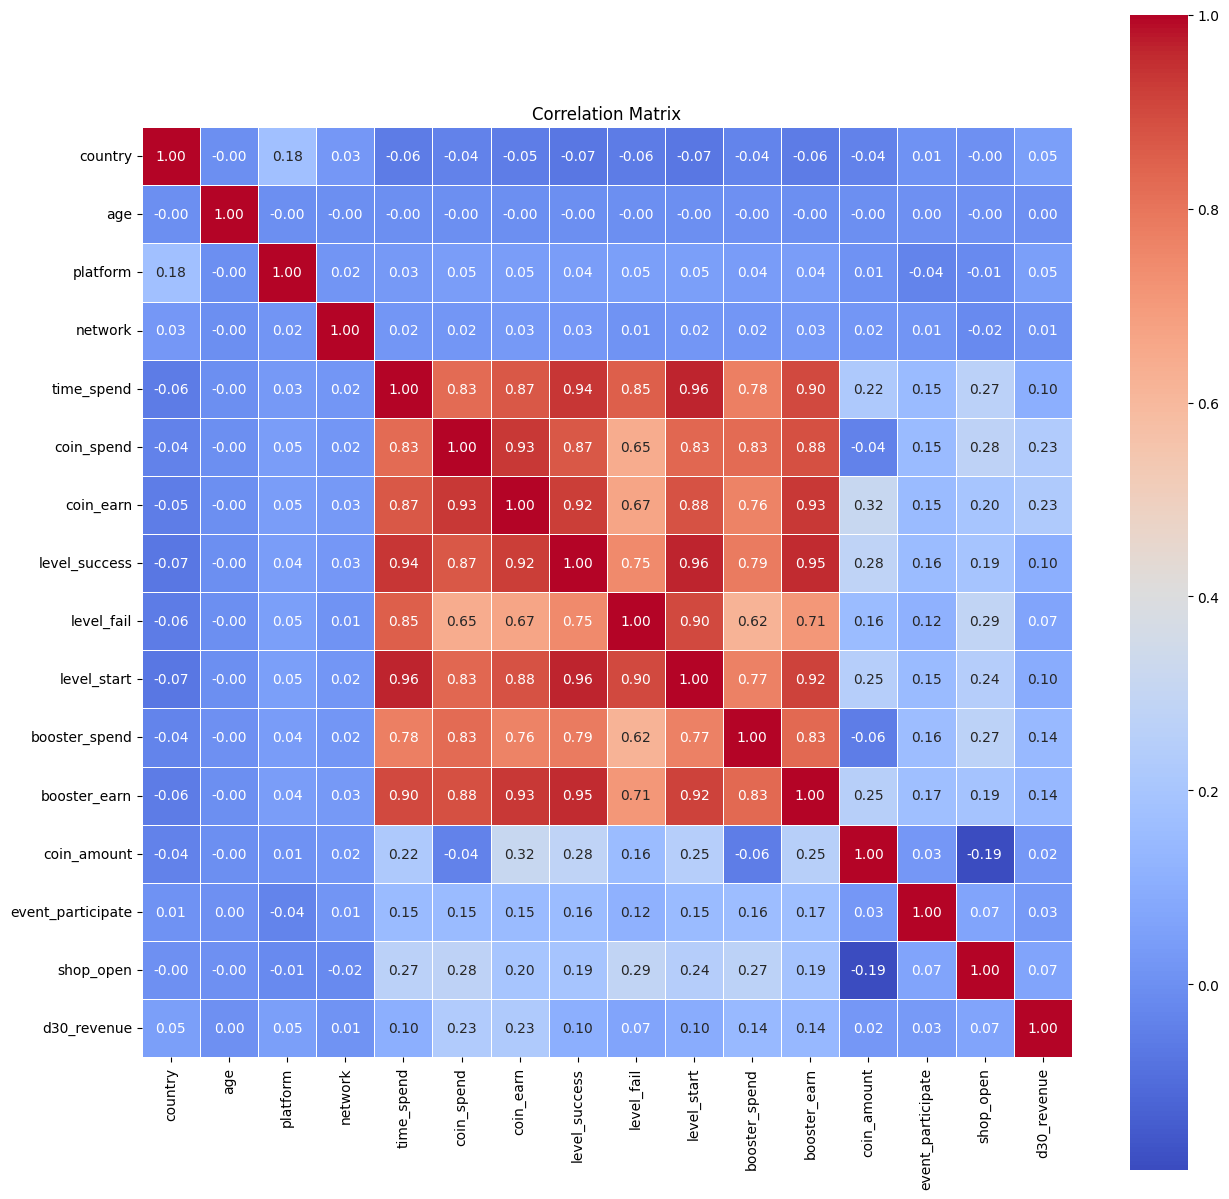

In [27]:
# Compute and visualize the correlation matrix for all numerical features
# This helps identify linear relationships and potential multicollinearity.

correlation_matrix = df_ml_1.corr()  # Compute pairwise correlations
plt.figure(figsize=(15, 15))
sns.heatmap(
    correlation_matrix,
    annot=True,            # Show correlation values
    square=True,           # Keep heatmap cells square
    cmap='coolwarm',       # Use diverging colormap
    fmt=".2f",             # Format correlation values to 2 decimal places
    linewidths=0.5         # Add space between cells
)
plt.title('Correlation Matrix')
plt.show()


In [28]:
# Convert 'd30_revenue' into a binary classification target:
# 1 if revenue is greater than 0, otherwise 0.

df_ml_1["d30_revenue"] = (df_ml_1["d30_revenue"] > 0).astype(int)

df_ml_1  # Display the updated DataFrame

,country,age,platform,network,time_spend,coin_spend,coin_earn,level_success,level_fail,level_start,booster_spend,booster_earn,coin_amount,event_participate,shop_open,d30_revenue
0,1.000000,0.000000,1.0,0.769231,0.000353,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.009890,0.0,0.000,0
1,0.894737,0.000000,1.0,0.846154,0.000437,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.009890,0.0,0.000,0
2,0.842105,0.000000,1.0,0.846154,0.000010,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.009890,0.0,0.000,0
3,1.000000,0.000000,1.0,0.846154,0.000055,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.009890,0.0,0.000,0
4,1.000000,0.333333,1.0,0.846154,0.000189,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.009890,0.0,0.000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
342514,0.421053,0.000000,0.0,0.615385,0.175058,0.115617,0.098443,0.383459,0.148545,0.304762,0.237154,0.417526,0.001108,1.0,0.008,1
342515,0.263158,0.666667,0.0,0.384615,0.163804,0.101998,0.097050,0.383459,0.145482,0.303030,0.369565,0.312715,0.001286,0.0,0.008,0
342516,0.000000,0.666667,0.0,0.846154,0.280614,0.032688,0.104632,0.383459,0.206738,0.337662,0.037549,0.288660,0.116373,0.0,0.000,0
342517,0.947368,0.000000,0.0,0.846154,0.162056,0.065981,0.074341,0.383459,0.134763,0.296970,0.110672,0.223368,0.034674,1.0,0.000,0


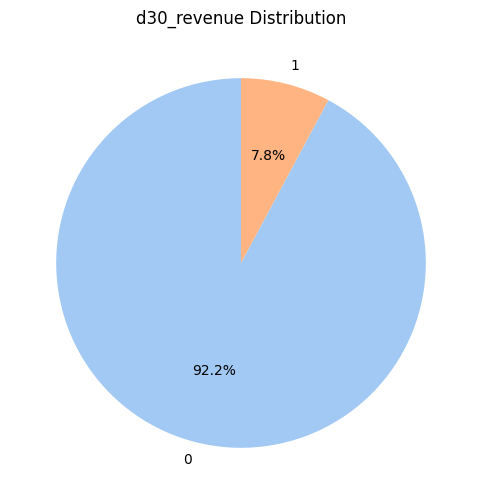

In [29]:
# Visualize the class distribution of the binary target 'd30_revenue' using a pie chart.
# Helps to check for class imbalance in the dataset.

categories = df_ml_1['d30_revenue'].unique()
num_of_categories = df_ml_1['d30_revenue'].value_counts()

plt.figure(figsize=(6, 6))
plt.pie(
    num_of_categories,
    labels=categories,
    autopct='%1.1f%%',  # Show percentage labels
    startangle=90,      # Rotate start angle for aesthetics
    colors=sns.color_palette('pastel', len(categories))  # Use pastel color palette
)
plt.title('d30_revenue Distribution')
plt.show()


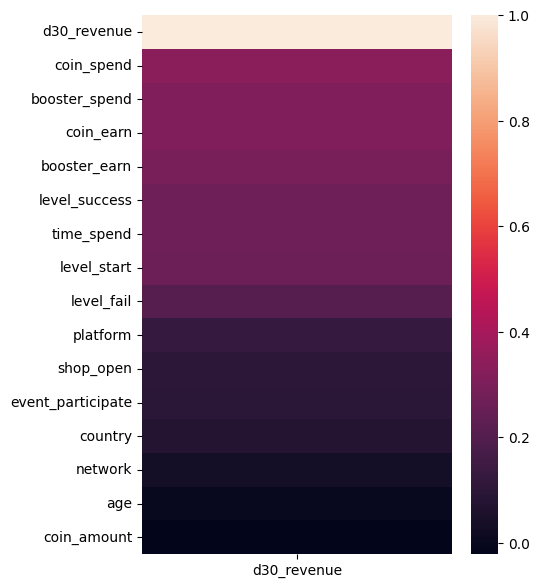

In [30]:
# Plot a heatmap showing how each feature correlates with the binary target 'd30_revenue'.
# Helps identify which features may be predictive.

plt.figure(figsize=(5, 7))
heatmap = sns.heatmap(
    df_ml_1.corr()[["d30_revenue"]].sort_values(by="d30_revenue", ascending=False),  # Sort by correlation strength
    annot=True,  # Display correlation values in the heatmap
    cmap='coolwarm'  # Optional: set a colormap for visual clarity
)


## Data Visualization

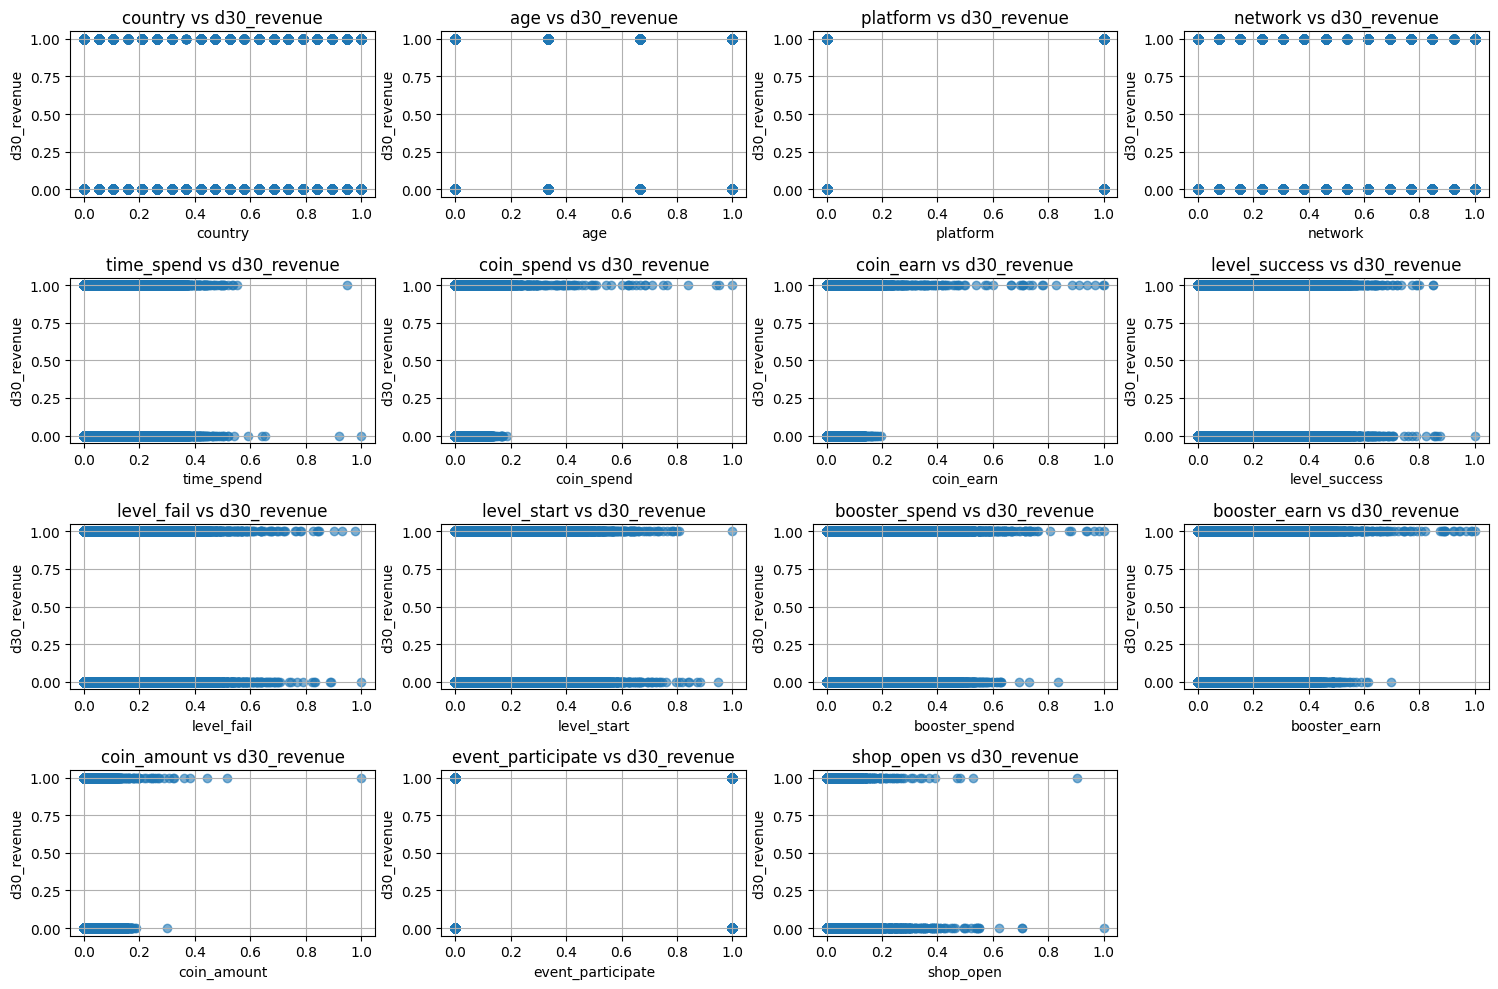

In [32]:
# This function generates scatter plots between each numerical feature and the target column.
# Useful for visualizing potential relationships or patterns relevant for predictive modeling.

def scatter_plots_against_target(df, target_column):
    features = df.drop(columns=[target_column])
    numeric_cols = features.select_dtypes(include=['number']).columns  # Select only numeric features

    num_plots = len(numeric_cols)
    rows, cols = 4, 4  # Define grid dimensions for subplots
    fig, axes = plt.subplots(rows, cols, figsize=(15, 10))
    axes = axes.flatten()  # Flatten the 2D array of axes

    for i, col in enumerate(numeric_cols):
        axes[i].scatter(df[col], df[target_column], alpha=0.6)  # Scatter plot with transparency
        axes[i].set_title(f'{col} vs {target_column}')
        axes[i].set_xlabel(col)
        axes[i].set_ylabel(target_column)
        axes[i].grid(True)

    # Remove unused subplots if number of features < grid size
    for j in range(i + 1, rows * cols):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

# Call the function to generate plots
scatter_plots_against_target(df_ml_1, target_column='d30_revenue')


## Evaluation Funcs

In [34]:
# This function evaluates a classification model's performance by:
# - Printing accuracy
# - Displaying a classification report
# - Plotting a confusion matrix heatmap
# It also logs accuracy to a provided list for later aggregation/comparison.

def present_classification_result(test, pred, accuracy_list):
    accuracy = accuracy_score(test, pred)
    accuracy_list.append(accuracy)  # Log the accuracy for tracking
    print(f"Accuracy: {accuracy:.4f}")

    print("-------Classification Report-------")
    print(classification_report(test, pred))  # Precision, recall, f1-score

    conf_matrix = confusion_matrix(test, pred)
    print("-------Confusion Matrix-------")
    class_labels = sorted(set(test) | set(pred))  # Ensure consistent labels

    # Visualize confusion matrix as a heatmap
    sns.heatmap(
        conf_matrix, annot=True, fmt='d', cmap='coolwarm',
        xticklabels=class_labels, yticklabels=class_labels
    )
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Class')
    plt.ylabel('True Class')
    plt.show()


In [35]:
# This function plots ROC (Receiver Operating Characteristic) curves for multiple classifiers.
# It compares their true positive vs. false positive rates and annotates each with its AUC score.

def draw_ROC(classifiers, y_pred_probs, y_test):
    plt.figure(figsize=(10, 8))
    i = 0
    for y_pred_prob in y_pred_probs:
        fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)  # Compute ROC curve
        auc = roc_auc_score(y_test, y_pred_prob)  # Compute AUC score
        # Plot ROC curve with classifier name and AUC
        plt.plot(fpr, tpr, label=f'{classifiers[i].__class__.__name__} (AUC = {auc:.2f})')
        i += 1

    # Plot diagonal reference line (random guessing)
    plt.plot([0, 1], [0, 1], linestyle='--', color='black', label='Random Guessing')

    plt.title('ROC Curves for Different Classifiers')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.show()


# Models

In [36]:
accuracy_list = []
models = []
y_pred_probs = []

In [37]:
# Split the dataset into training and test sets for model evaluation.
# 80% of the data is used for training and 20% for testing.

X = df_ml_1.drop("d30_revenue", axis=1)  # Features
y = df_ml_1["d30_revenue"]               # Target

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42  # Fixed seed for reproducibility
)

# Print the shape of the resulting splits
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)


(274015, 15)
(68504, 15)
(274015,)
(68504,)


## Logistic Regression

-------Logistic Regression-------
Accuracy: 0.9255
-------Classification Report-------
              precision    recall  f1-score   support

           0       0.93      0.99      0.96     63159
           1       0.62      0.12      0.19      5345

    accuracy                           0.93     68504
   macro avg       0.78      0.55      0.58     68504
weighted avg       0.91      0.93      0.90     68504

-------Confusion Matrix-------


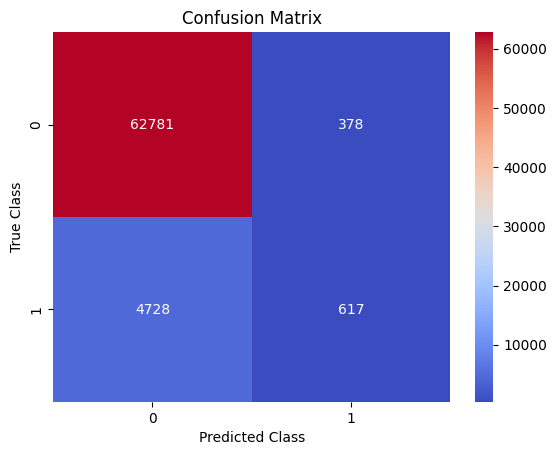

In [38]:
print("-------Logistic Regression-------")
lr_model = LogisticRegression()
lr_model.fit(X_train, y_train)
y_pred_lr = lr_model.predict(X_test)
y_pred_prob_lr = lr_model.predict_proba(X_test)[:, 1]
models.append(lr_model)
y_pred_probs.append(y_pred_prob_lr)

present_classification_result(y_test, y_pred_lr,accuracy_list)

## KNN Classification

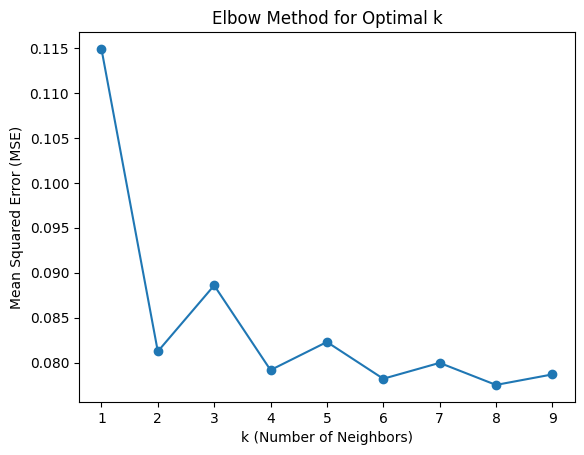

In [40]:
# Elbow Method to decide best k.
k_values = range(1, 10)
mse_values = []

for k in k_values:
    knn_model = KNeighborsClassifier(n_neighbors=k)
    knn_model.fit(X_train, y_train)
    y_pred = knn_model.predict(X_test)
    mse = metrics.mean_squared_error(y_test, y_pred)
    mse_values.append(mse)

plt.plot(k_values, mse_values, marker='o')
plt.xlabel('k (Number of Neighbors)')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('Elbow Method for Optimal k')
plt.show()

-------KNN Classifier-------
Accuracy: 0.9208
-------Classification Report-------
              precision    recall  f1-score   support

           0       0.93      0.99      0.96     63159
           1       0.46      0.10      0.16      5345

    accuracy                           0.92     68504
   macro avg       0.70      0.54      0.56     68504
weighted avg       0.89      0.92      0.90     68504

-------Confusion Matrix-------


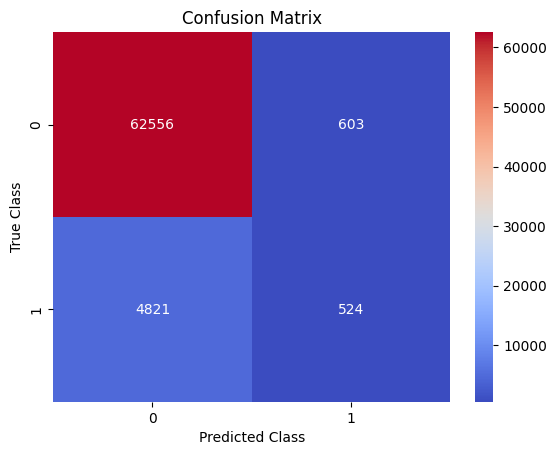

In [41]:
print("-------KNN Classifier-------")
knn_model = KNeighborsClassifier(n_neighbors=4)
knn_model.fit(X_train, y_train)
y_pred_knn = knn_model.predict(X_test)
y_pred_prob_knn = knn_model.predict_proba(X_test)[:, 1]
models.append(knn_model)
y_pred_probs.append(y_pred_prob_knn)

present_classification_result(y_test,y_pred_knn,accuracy_list)

## Naive Bayes Classification

-------Naive Bayes-------
Accuracy: 0.8413
-------Classification Report-------
              precision    recall  f1-score   support

           0       0.95      0.87      0.91     63159
           1       0.23      0.45      0.31      5345

    accuracy                           0.84     68504
   macro avg       0.59      0.66      0.61     68504
weighted avg       0.89      0.84      0.86     68504

-------Confusion Matrix-------


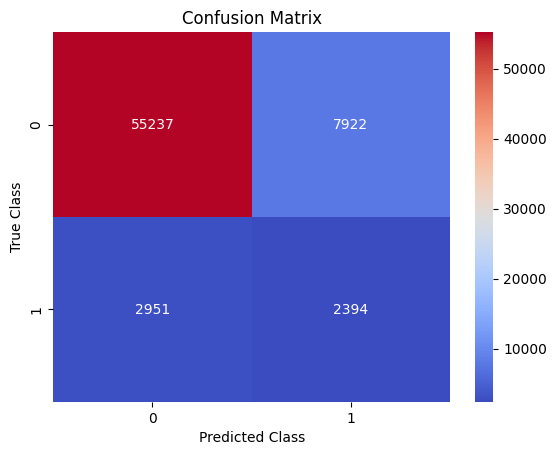

In [42]:
print("-------Naive Bayes-------")
nb_classifier = GaussianNB()
nb_classifier.fit(X_train, y_train)
y_pred_nb = nb_classifier.predict(X_test)
y_pred_prob_nb = nb_classifier.predict_proba(X_test)[:, 1]
models.append(nb_classifier)
y_pred_probs.append(y_pred_prob_nb)

present_classification_result(y_test,y_pred_nb,accuracy_list)

## Decision Tree Classification

-------Decision Tree Classification-------
Accuracy: 0.8823
-------Classification Report-------
              precision    recall  f1-score   support

           0       0.94      0.93      0.94     63159
           1       0.28      0.31      0.29      5345

    accuracy                           0.88     68504
   macro avg       0.61      0.62      0.61     68504
weighted avg       0.89      0.88      0.89     68504

-------Confusion Matrix-------


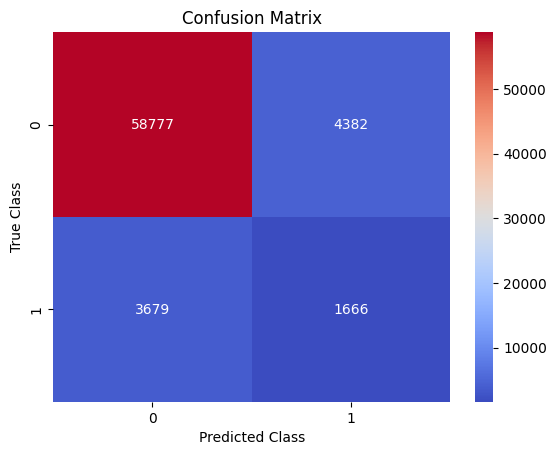

In [43]:
print("-------Decision Tree Classification-------")
dt_classifier = DecisionTreeClassifier(random_state=42)
dt_classifier.fit(X_train, y_train)
y_pred_dt = dt_classifier.predict(X_test)
y_pred_prob_dt = dt_classifier.predict_proba(X_test)[:, 1]
models.append(dt_classifier)
y_pred_probs.append(y_pred_prob_dt)

present_classification_result(y_test,y_pred_dt,accuracy_list)

## Random Forest Classification

-------Random Forest Classification-------
Accuracy: 0.9304
-------Classification Report-------
              precision    recall  f1-score   support

           0       0.93      0.99      0.96     63159
           1       0.73      0.17      0.28      5345

    accuracy                           0.93     68504
   macro avg       0.83      0.58      0.62     68504
weighted avg       0.92      0.93      0.91     68504

-------Confusion Matrix-------


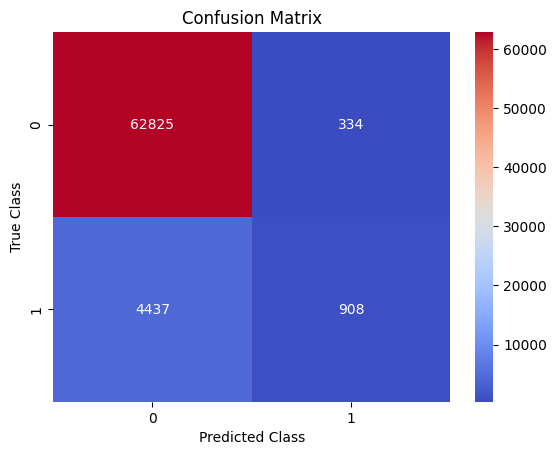

In [44]:
print("-------Random Forest Classification-------")
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train, y_train)
y_pred_rf = rf_classifier.predict(X_test)
y_pred_prob_rf = rf_classifier.predict_proba(X_test)[:, 1]
models.append(rf_classifier)
y_pred_probs.append(y_pred_prob_rf)

present_classification_result(y_test,y_pred_rf,accuracy_list)

## Gradient Boosting Classification

-------Gradient Boosting Classification-------
Accuracy: 0.9299
-------Classification Report-------
              precision    recall  f1-score   support

           0       0.93      1.00      0.96     63159
           1       0.78      0.14      0.24      5345

    accuracy                           0.93     68504
   macro avg       0.85      0.57      0.60     68504
weighted avg       0.92      0.93      0.91     68504

-------Confusion Matrix-------


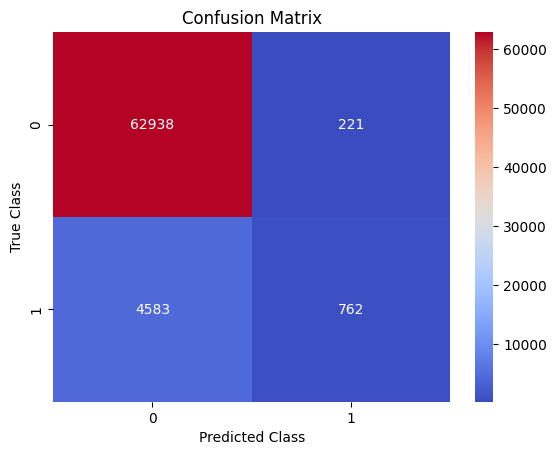

In [45]:
print("-------Gradient Boosting Classification-------")
gb_classifier = GradientBoostingClassifier(n_estimators=100, random_state=42)
gb_classifier.fit(X_train, y_train)
y_pred_gb = gb_classifier.predict(X_test)
y_pred_prob_gb = gb_classifier.predict_proba(X_test)[:, 1]
models.append(gb_classifier)
y_pred_probs.append(y_pred_prob_gb)

present_classification_result(y_test,y_pred_gb,accuracy_list)

## Neural Network 1

Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7707/7707 ━━━━━━━━━━━━━━━━━━━━ 23s 3ms/step - accuracy: 0.9185 - loss: 0.2493 - val_accuracy: 0.9252 - val_loss: 0.2118
Epoch 2/20
7707/7707 ━━━━━━━━━━━━━━━━━━━━ 38s 2ms/step - accuracy: 0.9247 - loss: 0.2168 - val_accuracy: 0.9270 - val_loss: 0.2075
Epoch 3/20
7707/7707 ━━━━━━━━━━━━━━━━━━━━ 19s 2ms/step - accuracy: 0.9260 - loss: 0.2136 - val_accuracy: 0.9283 - val_loss: 0.2055
Epoch 4/20
7707/7707 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step - accuracy: 0.9280 - loss: 0.2090 - val_accuracy: 0.9274 - val_loss: 0.2064
Epoch 5/20
7707/7707 ━━━━━━━━━━━━━━━━━━━━ 18s 2ms/step - accuracy: 0.9273 - loss: 0.2102 - val_accuracy: 0.9277 - val_loss: 0.2063
Epoch 6/20
7707/7707 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - accuracy: 0.9283 - loss: 0.2075 - val_accuracy: 0.9283 - val_loss: 0.2037
Epoch 7/20
7707/7707 ━━━━━━━━━━━━━━━━━━━━ 19s 2ms/step - accuracy: 0.9279 - loss: 0.2094 - val_accuracy: 0.9292 - val_loss: 0.2025
Epoch 8/20
7707/7707 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - accuracy: 0.9274 - loss: 0.2102 - val

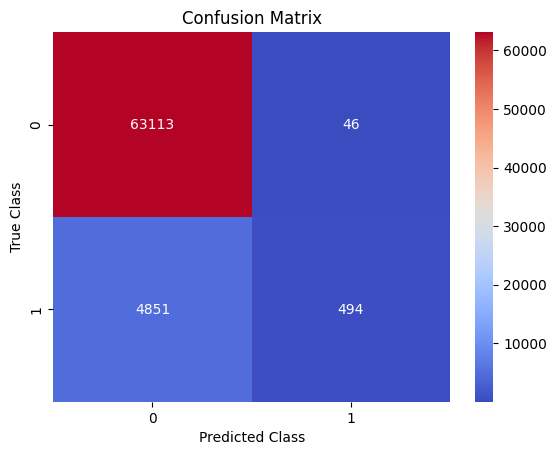

In [48]:
# Build, compile, and train a simple feedforward neural network for binary classification (d30_revenue).
# Then evaluate its performance and store predictions for further comparison.

nn_model = Sequential([
    Dense(64, input_dim=X_train.shape[1], activation='relu'),  # First hidden layer with ReLU
    Dropout(0.3),                                               # Dropout to reduce overfitting
    Dense(32, activation='relu'),                               # Second hidden layer
    Dropout(0.2),                                               # Another dropout layer
    Dense(1, activation='sigmoid')                              # Output layer for binary classification
])

# Compile the model with binary cross-entropy loss and Adam optimizer
nn_model.compile(
    loss='binary_crossentropy',
    optimizer=Adam(learning_rate=0.001),
    metrics=['accuracy']
)

# Train the model with 10% of training data used for validation
nn_model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    verbose=1,
    validation_split=0.1
)

# Generate predictions
y_pred_prob_nn = nn_model.predict(X_test).ravel()  # Get probabilities
y_pred_nn = (y_pred_prob_nn > 0.5).astype(int)     # Convert to class labels

# Store model and predictions for later evaluation
models.append(nn_model)
y_pred_probs.append(y_pred_prob_nn)

# Present performance results
present_classification_result(y_test, y_pred_nn, accuracy_list)


## Neural Network 2

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7707/7707 ━━━━━━━━━━━━━━━━━━━━ 23s 3ms/step - accuracy: 0.6954 - loss: 0.5571 - val_accuracy: 0.7446 - val_loss: 0.4715
Epoch 2/10
7707/7707 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - accuracy: 0.7278 - loss: 0.5023 - val_accuracy: 0.7556 - val_loss: 0.4605
Epoch 3/10
7707/7707 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - accuracy: 0.7349 - loss: 0.4945 - val_accuracy: 0.7355 - val_loss: 0.5023
Epoch 4/10
7707/7707 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step - accuracy: 0.7333 - loss: 0.4999 - val_accuracy: 0.7266 - val_loss: 0.5130
Epoch 5/10
7707/7707 ━━━━━━━━━━━━━━━━━━━━ 20s 2ms/step - accuracy: 0.7354 - loss: 0.4944 - val_accuracy: 0.7414 - val_loss: 0.5138
Epoch 6/10
7707/7707 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step - accuracy: 0.7458 - loss: 0.4949 - val_accuracy: 0.7057 - val_loss: 0.5382
Epoch 7/10
7707/7707 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - accuracy: 0.7423 - loss: 0.4847 - val_accuracy: 0.7703 - val_loss: 0.4454
Epoch 8/10
7707/7707 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - accuracy: 0.7438 - loss: 0.4866 - val

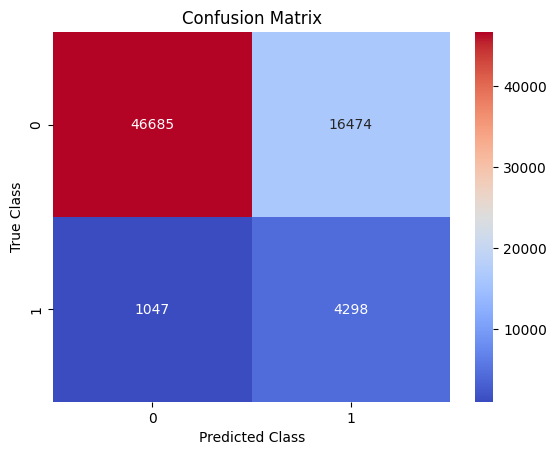

In [53]:
# Compute class weights from training labels
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = {cls: weight for cls, weight in zip(np.unique(y_train), class_weights)}

# Build, compile, and train a simple feedforward neural network for binary classification (d30_revenue)
# Then evaluate its performance and store predictions for further comparison

nn_model_weighted = Sequential([
    Dense(64, input_dim=X_train.shape[1], activation='relu'),  # First hidden layer with ReLU
    Dropout(0.3),                                               # Dropout to reduce overfitting
    Dense(32, activation='relu'),                               # Second hidden layer
    Dropout(0.2),                                               # Another dropout layer
    Dense(1, activation='sigmoid')                              # Output layer for binary classification
])

# Compile the model with binary cross-entropy loss and Adam optimizer
nn_model_weighted.compile(
    loss='binary_crossentropy',
    optimizer=Adam(learning_rate=0.001),
    metrics=['accuracy']
)

# Train the model with class weights and 10% validation split
nn_model_weighted.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32,
    verbose=1,
    validation_split=0.1,
    class_weight=class_weight_dict  # Apply computed class weights
)

# Generate predictions
y_pred_prob_nn = nn_model_weighted.predict(X_test).ravel()  # Get probabilities
y_pred_nn = (y_pred_prob_nn > 0.5).astype(int)     # Convert to class labels

# Store model and predictions for later evaluation
models.append(nn_model_weighted)
y_pred_probs.append(y_pred_prob_nn)

# Present performance results
present_classification_result(y_test, y_pred_nn, accuracy_list)

## Transformer Based

In [69]:
from tensorflow.keras.layers import Input, Dense, Dropout, LayerNormalization, MultiHeadAttention, Add, Lambda
from tensorflow.keras.models import Model
import tensorflow as tf

In [67]:
def transformer_block(inputs, num_heads=4, ff_dim=64, dropout_rate=0.1):
    # Multi-head self-attention
    attention_output = MultiHeadAttention(num_heads=num_heads, key_dim=inputs.shape[-1])(inputs, inputs)
    attention_output = Dropout(dropout_rate)(attention_output)
    attention_output = Add()([inputs, attention_output])
    attention_output = LayerNormalization()(attention_output)

    # Feed-forward layer
    ff_output = Dense(ff_dim, activation='relu')(attention_output)
    ff_output = Dense(inputs.shape[-1])(ff_output)
    ff_output = Dropout(dropout_rate)(ff_output)
    ff_output = Add()([attention_output, ff_output])
    ff_output = LayerNormalization()(ff_output)

    return ff_output

def build_tabular_transformer(input_dim):
    inputs = Input(shape=(input_dim,))

    # Use Lambda layers to expand and squeeze dimensions inside the model
    x = Lambda(lambda t: tf.expand_dims(t, axis=1))(inputs)  # (batch, 1, features)

    x = transformer_block(x)  # Transformer expects 3D input
    x = Lambda(lambda t: tf.squeeze(t, axis=1))(x)  # (batch, features)

    x = Dense(64, activation='relu')(x)
    x = Dropout(0.3)(x)
    x = Dense(32, activation='relu')(x)
    x = Dropout(0.2)(x)
    outputs = Dense(1, activation='sigmoid')(x)

    model = Model(inputs, outputs)
    return model

In [70]:
transformer_model = build_tabular_transformer(X_train.shape[1])

transformer_model.compile(
    loss='binary_crossentropy',
    optimizer=Adam(learning_rate=0.001),
    metrics=['accuracy']
)

transformer_model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32,
    validation_split=0.1,
    verbose=1
)

Epoch 1/10
7707/7707 ━━━━━━━━━━━━━━━━━━━━ 36s 4ms/step - accuracy: 0.9209 - loss: 0.2394 - val_accuracy: 0.9262 - val_loss: 0.2106
Epoch 2/10
7707/7707 ━━━━━━━━━━━━━━━━━━━━ 32s 3ms/step - accuracy: 0.9261 - loss: 0.2178 - val_accuracy: 0.9258 - val_loss: 0.2079
Epoch 3/10
7707/7707 ━━━━━━━━━━━━━━━━━━━━ 25s 3ms/step - accuracy: 0.9270 - loss: 0.2136 - val_accuracy: 0.9289 - val_loss: 0.2072
Epoch 4/10
7707/7707 ━━━━━━━━━━━━━━━━━━━━ 41s 3ms/step - accuracy: 0.9272 - loss: 0.2124 - val_accuracy: 0.9281 - val_loss: 0.2107
Epoch 5/10
7707/7707 ━━━━━━━━━━━━━━━━━━━━ 40s 3ms/step - accuracy: 0.9271 - loss: 0.2120 - val_accuracy: 0.9275 - val_loss: 0.2070
Epoch 6/10
7707/7707 ━━━━━━━━━━━━━━━━━━━━ 42s 3ms/step - accuracy: 0.9271 - loss: 0.2123 - val_accuracy: 0.9294 - val_loss: 0.2039
Epoch 7/10
7707/7707 ━━━━━━━━━━━━━━━━━━━━ 24s 3ms/step - accuracy: 0.9275 - loss: 0.2105 - val_accuracy: 0.9297 - val_loss: 0.2027
Epoch 8/10
7707/7707 ━━━━━━━━━━━━━━━━━━━━ 41s 3ms/step - accuracy: 0.9275 - loss: 0

2141/2141 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
Accuracy: 0.9293
-------Classification Report-------
              precision    recall  f1-score   support

           0       0.93      1.00      0.96     63159
           1       0.77      0.13      0.23      5345

    accuracy                           0.93     68504
   macro avg       0.85      0.56      0.59     68504
weighted avg       0.92      0.93      0.91     68504

-------Confusion Matrix-------


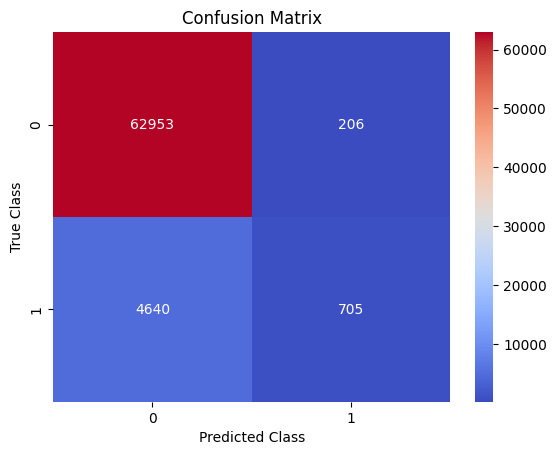

In [71]:
y_pred_prob_tf = transformer_model.predict(X_test).ravel()
y_pred_tf = (y_pred_prob_tf > 0.5).astype(int)

models.append(transformer_model)
y_pred_probs.append(y_pred_prob_tf)

present_classification_result(y_test, y_pred_tf, accuracy_list)

# Evaluation

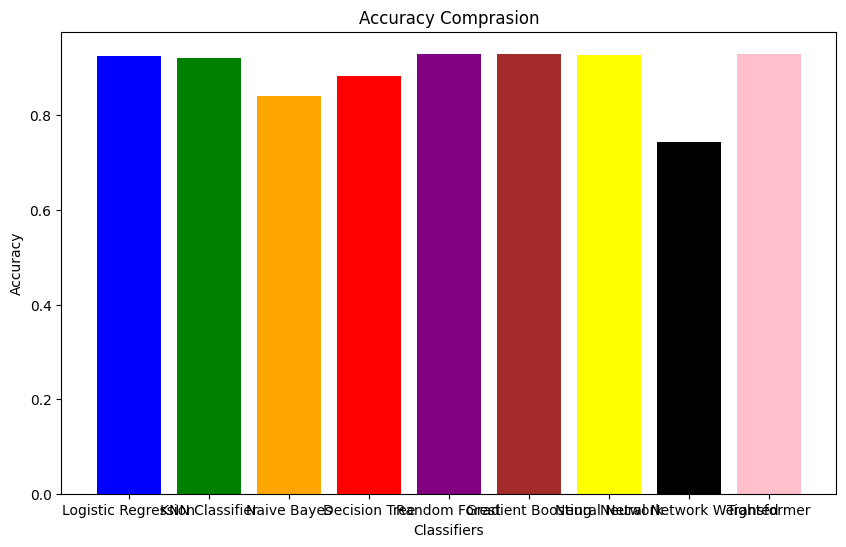

In [76]:
classifiers = ['Logistic Regression', 'KNN Classifier', 'Naive Bayes', 'Decision Tree', 'Random Forest', 'Gradient Boosting','Neural Network','Neural Network Weighted','Transformer']
plt.figure(figsize=(10, 6))
plt.bar(classifiers, accuracy_list, color=['blue', 'green', 'orange', 'red', 'purple', 'brown', 'yellow', 'black','pink'])
plt.title('Accuracy Comprasion')
plt.xlabel('Classifiers')
plt.ylabel('Accuracy')
plt.show()

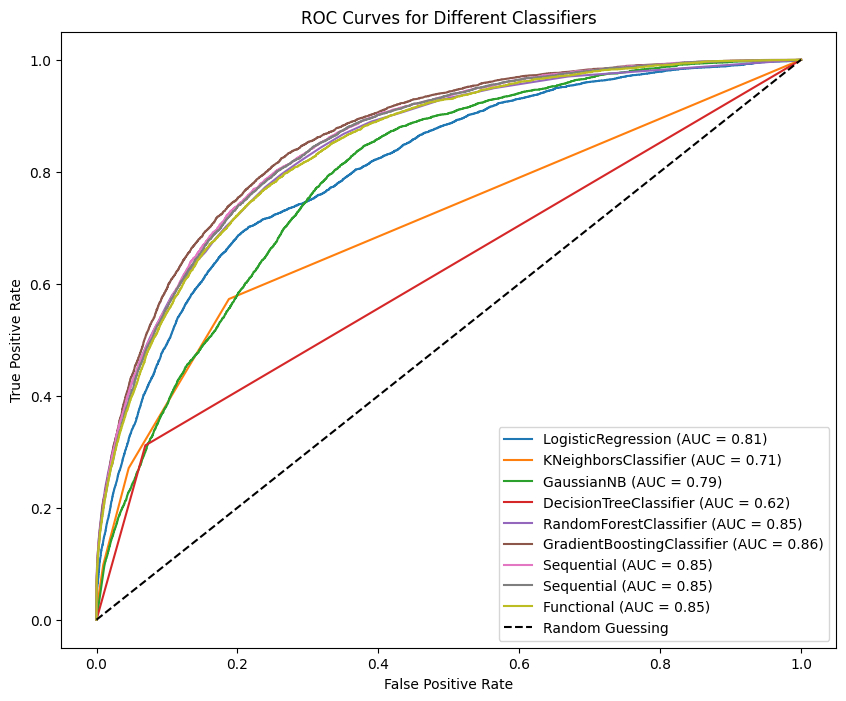

In [77]:
draw_ROC(models,y_pred_probs,y_test)